In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [3]:
# Tentukan direktori dataset
data_dir = r'C:\Users\pasar\Machine Learning\NEW\Prediksi Biji dataset\train'

# Memeriksa apakah direktori data train ada
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Direktori data train tidak ditemukan di: {data_dir}")

# Memuat file gambar dengan label dari folder "baik" dan "buruk"
categories = ['baik', 'buruk']

# Membuat list untuk menyimpan data
filepaths = []
labels = []

# Iterasi melalui kategori
for category in categories:
    category_path = os.path.join(data_dir, category)
    
    if not os.path.exists(category_path):
        raise FileNotFoundError(f"Folder kategori {category} tidak ditemukan di: {category_path}")
    
    # Menambahkan file dan label ke daftar
    for filename in os.listdir(category_path):
        filepaths.append(os.path.join(category_path, filename))
        labels.append(category)

# Membuat DataFrame
df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Tampilkan data awal
print(df.head())
print(df['labels'].value_counts())


                                           filepaths labels
0  C:\Users\pasar\Machine Learning\NEW\Prediksi B...   baik
1  C:\Users\pasar\Machine Learning\NEW\Prediksi B...   baik
2  C:\Users\pasar\Machine Learning\NEW\Prediksi B...   baik
3  C:\Users\pasar\Machine Learning\NEW\Prediksi B...   baik
4  C:\Users\pasar\Machine Learning\NEW\Prediksi B...   baik
labels
buruk    515
baik     513
Name: count, dtype: int64


In [5]:
# Fungsi untuk memproses gambar
def process_images(image_paths, target_size=(128, 128)):
    images = []  # Hapus 'A' yang tidak perlu
    for path in image_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalisasi
        images.append(img_array)
    return np.array(images)


In [7]:
# Definisikan X dan y dari DataFrame
X = df['filepaths'].values
y = df['labels'].values

# Bagi data menjadi train, validation, dan test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Tampilkan jumlah sampel
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_valid.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


Training samples: 822
Validation samples: 103
Test samples: 103


In [9]:
# Fungsi untuk memuat dan memproses gambar
def load_images(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  # Muat gambar
        img_array = img_to_array(img) / 255.0         # Normalisasi [0, 1]
        images.append(img_array)
    return np.array(images)

# Muat data gambar
X_train_images = load_images(X_train)
X_valid_images = load_images(X_valid)
X_test_images = load_images(X_test)

# Flatten data
X_train_flat = X_train_images.reshape(X_train_images.shape[0], -1)
X_valid_flat = X_valid_images.reshape(X_valid_images.shape[0], -1)
X_test_flat = X_test_images.reshape(X_test_images.shape[0], -1)

# Normalisasi dengan StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_valid_scaled = scaler.transform(X_valid_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Tampilkan hasil normalisasi
print(f"Data latih: {X_train_scaled.shape}")
print(f"Data validasi: {X_valid_scaled.shape}")
print(f"Data uji: {X_test_scaled.shape}")


Data latih: (822, 150528)
Data validasi: (103, 150528)
Data uji: (103, 150528)


In [ ]:
from sklearn.model_selection import learning_curve

# Inisialisasi model SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Membuat learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=svm_model, 
    X=X_train_scaled, 
    y=y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),  # Ukuran data latih (dari 10% hingga 100%)
    cv=5,  # Cross-validation dengan 5 fold
    scoring='accuracy', 
    n_jobs=-1
)

# Menghitung rata-rata dan standar deviasi untuk setiap ukuran data latih
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Visualisasi learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue', marker='o')
plt.plot(train_sizes, valid_mean, label='Validation Accuracy', color='green', marker='o')

# Menambahkan area bayangan untuk standar deviasi
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color='green', alpha=0.2)

# Menambahkan label dan judul
plt.title("Learning Curve for SVM (Accuracy vs. Training Size)")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Melatih model pada data training
svm_model.fit(X_train_scaled, y_train)


Classification Report (Test Set):
              precision    recall  f1-score   support

        baik       0.98      0.96      0.97        52
       buruk       0.96      0.98      0.97        51

    accuracy                           0.97       103
   macro avg       0.97      0.97      0.97       103
weighted avg       0.97      0.97      0.97       103



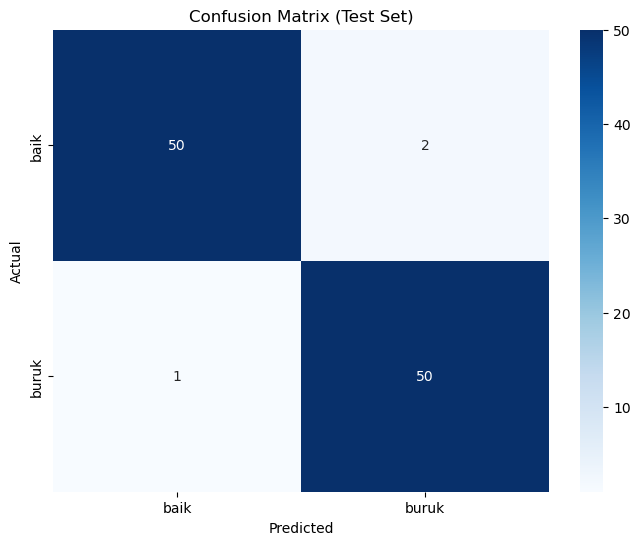

In [24]:
# Langkah 1: Terapkan PCA yang sama untuk data uji (mengurangi dimensi menjadi 2 fitur)
X_test_pca = pca.transform(X_test_scaled)

# Langkah 2: Prediksi pada data uji
y_test_pred = svm_model.predict(X_test_pca)

# Langkah 3: Laporan klasifikasi
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Langkah 4: Matriks kebingungan
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()


Classification Report (Test Set):
              precision    recall  f1-score   support

        baik       0.98      0.96      0.97        52
       buruk       0.96      0.98      0.97        51

    accuracy                           0.97       103
   macro avg       0.97      0.97      0.97       103
weighted avg       0.97      0.97      0.97       103



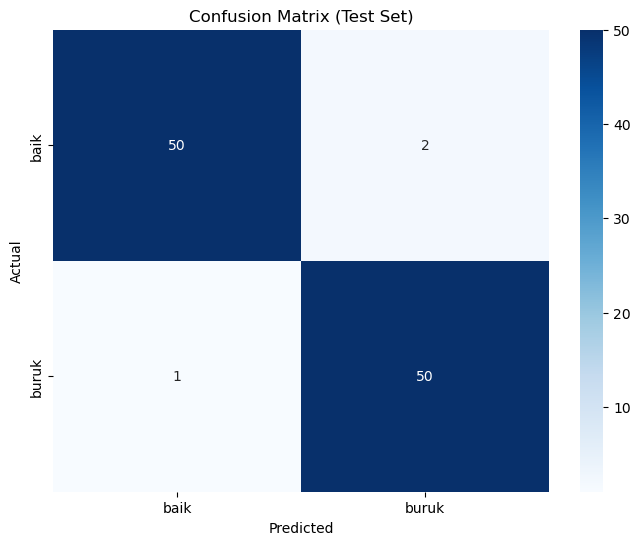

In [26]:
# Terapkan PCA yang telah dipelajari ke data uji (mengurangi dimensi menjadi 2 fitur)
X_test_pca = pca.transform(X_test_scaled)

# Prediksi pada data uji menggunakan model SVM
y_test_pred = svm_model.predict(X_test_pca)

# Laporan klasifikasi
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Matriks kebingungan
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()


In [27]:
# Langkah 11: Menyimpan Model SVM dan Scaler

import joblib

# Menyimpan model SVM
joblib.dump(svm_model, 'svm_model.pkl')

# Menyimpan scaler yang sudah di-fit
joblib.dump(scaler, 'scaler.pkl')

# Menyimpan label encoder (untuk mengonversi label yang diprediksi kembali ke format asli)
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Model, scaler, dan label encoder telah disimpan.")


Model, scaler, dan label encoder telah disimpan.


In [28]:
#Langkah 12: Memuat Kembali Model, Scaler, dan Label Encoder untuk Prediksi Mendatang
# Memuat model SVM, scaler, dan label encoder
svm_model = joblib.load('svm_model.pkl')
scaler = joblib.load('scaler.pkl')
label_encoder = joblib.load('label_encoder.pkl')

print("Model, scaler, dan label encoder telah dimuat.")



Model, scaler, dan label encoder telah dimuat.


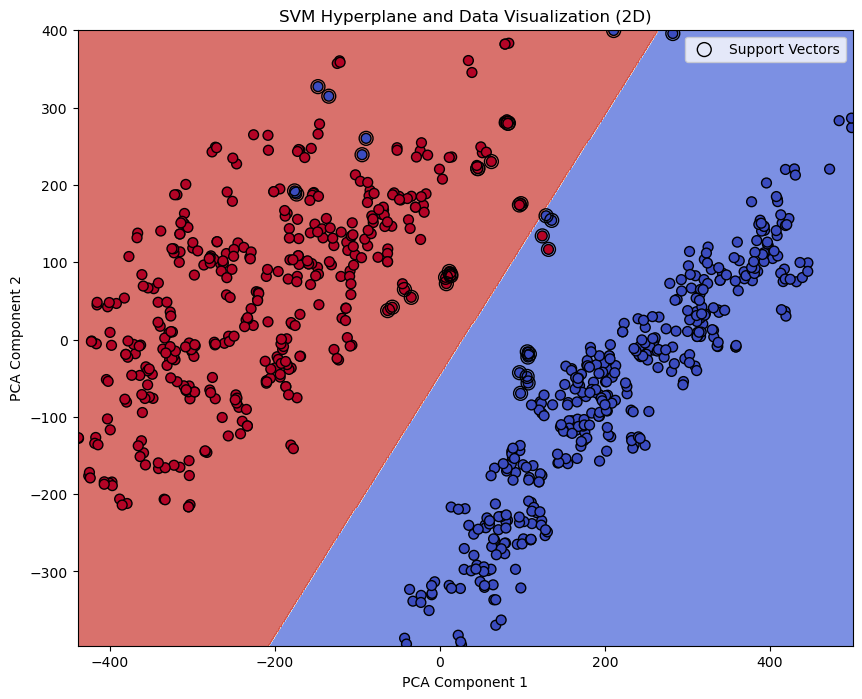

Jarak margin maksimum (distance to the hyperplane): 97.29766579661735


In [33]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

# Reduksi dimensi data ke 2D menggunakan PCA
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_scaled)

# Encode label string menjadi integer
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

# Membuat model SVM dan melatihnya
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_2d, y_train_encoded)

# Membuat mesh grid
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Prediksi kelas untuk grid
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Visualisasi Hyperplane
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.coolwarm)

# Visualisasi data training
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_encoded, cmap=plt.cm.coolwarm, edgecolors='k', s=50)
plt.title("SVM Hyperplane and Data Visualization (2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Menampilkan support vector
plt.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], 
            s=100, facecolors='none', edgecolors='k', label="Support Vectors")
plt.legend()
plt.show()

# Menampilkan margin hyperplane
print("Jarak margin maksimum (distance to the hyperplane):", 1 / np.linalg.norm(svm_model.coef_))


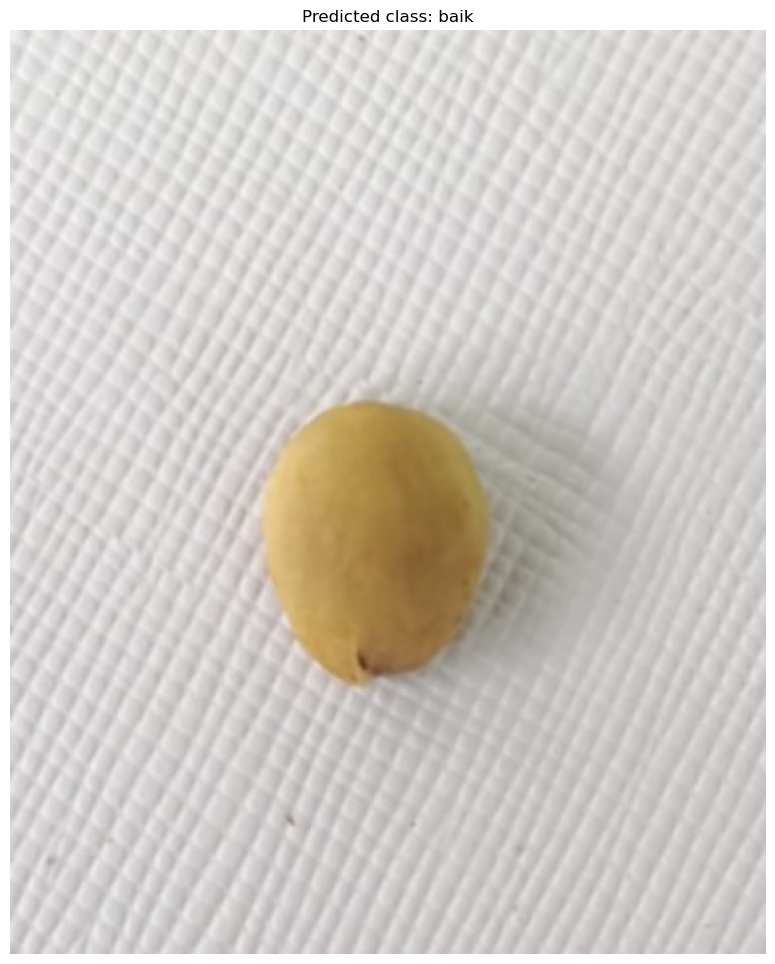

Prediksi Kualitas: baik
Penjelasan: Model mengklasifikasikan biji kopi sebagai 'baik'.


In [43]:
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Inisialisasi data dummy untuk pelatihan
X_train = np.random.rand(100, 128, 128, 3)  # Data dummy gambar RGB 128x128
y_train = np.random.choice(['baik', 'buruk'], 100)  # Label dummy

# Latih scaler pada data pelatihan
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(len(X_train), -1))

# Melatih model SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Latih LabelEncoder dengan label unik
label_encoder = LabelEncoder()
label_encoder.fit(np.unique(y_train))

# Fungsi untuk memproses gambar baru
def preprocess_image(img_path, target_size=(128, 128)):  
    # Memuat gambar dan mengubah ukurannya
    img = image.load_img(img_path, target_size=target_size)
    # Konversi gambar ke array numpy
    img_array = image.img_to_array(img) / 255.0  # Normalisasi
    # Flatten gambar untuk SVM
    img_array = img_array.flatten()
    # Normalisasi dengan scaler yang dilatih
    img_array = scaler.transform([img_array])  
    return img_array

# Path ke gambar biji kopi yang akan diprediksi
img_path = r'C:\Users\artha ms\SEMESTER 5\PM\Prediksi Biji dataset\baik.jpg'

# Preproses gambar dengan ukuran yang konsisten (128, 128)
new_img = preprocess_image(img_path, target_size=(128, 128))

# Prediksi dengan model SVM
prediction = svm_model.predict(new_img)

# Periksa apakah label prediksi ada dalam label encoder
if prediction[0] not in label_encoder.classes_:
    print(f"Error: Prediksi '{prediction[0]}' tidak ditemukan dalam label yang dikenali.")
else:
    # Menampilkan gambar asli dengan ukuran besar
    img = image.load_img(img_path)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.title(f"Predicted class: {prediction[0]}")
    plt.axis('off')
    plt.show()

    # Menampilkan hasil prediksi dengan penjelasan
    print(f"Prediksi Kualitas: {prediction[0]}")
    print(f"Penjelasan: Model mengklasifikasikan biji kopi sebagai '{prediction[0]}'.")
